### Test with 50000 Datapoints

In [1]:
import data as d

##### 5000 * 10 Datapoints, 1600 samples

In [2]:
data_list = d.get_data(5000, 16, 25, 10)

2818.06952
3152.92296


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import model_gru as m
import tree_net as TN
import imp
imp.reload(m)
imp.reload(TN)
imp.reload(TN.helper)


<module 'helper' from 'C:\\Users\\Hendrik\\Documents\\GitHub\\ModelTreeGRU\\helper.py'>

In [10]:
encoder_l0 = torch.load("models/encoder-h50-f50-s1600-b10-lin-adam-el0.mdl")
encoder_l1 = torch.load("models/encoder-h50-f50-s1600-b10-lin-adam-el1.mdl")

decoder_l0 = torch.load("models/decoder-h50-f50-s1600-b10-lin-adam-dl0.mdl")
decoder_l1 = torch.load("models/decoder-h50-f50-s1600-b10-lin-adam-dl1.mdl")

pretrained_models = [{'level': 0, 'encoder': encoder_l0, 'decoder': decoder_l0}, {'level': 1, 'encoder': encoder_l1, 'decoder': decoder_l1}]

In [11]:
tree_preproc = TN.TreeNet([50,250], 10, [50,10], 0.01, pretrained=pretrained_models)

Parameter list contains 0 entries!


In [12]:
data_chopped = []

loss_pp = nn.MSELoss()

for d in data_list:
    features = []
    for i in range(10):
        d_p = d[i*500:(i+1)*500]
        d_in = torch.from_numpy(d_p).float().cuda()
        feat = tree_preproc.forward(d_in)
        features.append(feat)

    data_chopped.append(torch.cat(features, dim=0).cpu().detach().numpy())

In [13]:
data_chopped[0].shape

(10, 16, 250)

In [16]:
tree_top_level = TN.TreeNet([500], 250, [10], 0.001)

loss_f = nn.MSELoss()

Parameter list contains 14 entries!


In [17]:
for e in range(500):
    
    avg_loss = 0.0
    
    for b in data_chopped:
        tree_top_level.zero_grad()
        
        b_t = torch.from_numpy(b).float().cuda()
        
        states = tree_top_level.forward(b_t)
        predicted = tree_top_level.backward(states)
        
        loss = loss_f(predicted, b_t)
        
        loss.backward()
        
        tree_top_level.optimizer.step()
        
        avg_loss += loss
        
    avg_loss /= len(data_list)
    
    print(e, avg_loss)
        

0 tensor(0.3890, device='cuda:0', grad_fn=<DivBackward0>)
1 tensor(0.3693, device='cuda:0', grad_fn=<DivBackward0>)
2 tensor(0.3648, device='cuda:0', grad_fn=<DivBackward0>)
3 tensor(0.3625, device='cuda:0', grad_fn=<DivBackward0>)
4 tensor(0.3545, device='cuda:0', grad_fn=<DivBackward0>)
5 tensor(0.3466, device='cuda:0', grad_fn=<DivBackward0>)
6 tensor(0.3429, device='cuda:0', grad_fn=<DivBackward0>)
7 tensor(0.3386, device='cuda:0', grad_fn=<DivBackward0>)
8 tensor(0.3335, device='cuda:0', grad_fn=<DivBackward0>)
9 tensor(0.3320, device='cuda:0', grad_fn=<DivBackward0>)
10 tensor(0.3278, device='cuda:0', grad_fn=<DivBackward0>)
11 tensor(0.3239, device='cuda:0', grad_fn=<DivBackward0>)
12 tensor(0.3153, device='cuda:0', grad_fn=<DivBackward0>)
13 tensor(0.3123, device='cuda:0', grad_fn=<DivBackward0>)
14 tensor(0.3153, device='cuda:0', grad_fn=<DivBackward0>)
15 tensor(0.3124, device='cuda:0', grad_fn=<DivBackward0>)
16 tensor(0.3086, device='cuda:0', grad_fn=<DivBackward0>)
17 tens

In [18]:
predicted.shape

torch.Size([10, 16, 250])

In [28]:
def apply(tens):
    features = []
    for i in range(10):
        d_p = d[i*500:(i+1)*500]
        d_in = torch.from_numpy(d_p).float().cuda()
        feat = tree_preproc.forward(d_in)
        features.append(feat)

    chopped = torch.cat(features, dim=0).cpu().detach().numpy()
    
    b_t = torch.from_numpy(chopped).float().cuda()
        
    states = tree_top_level.forward(b_t)
    predicted = tree_top_level.backward(states)
    
    back_pred = []
    for i in range(10):
        back_pred.append(tree_preproc.backward(predicted[i:i+1]))

    backwards_pred = torch.cat(back_pred, dim=0)
    
    return backwards_pred

In [30]:
apply(data_list[1]).shape

torch.Size([5000, 16, 10])

In [22]:
import matplotlib.pyplot as plt

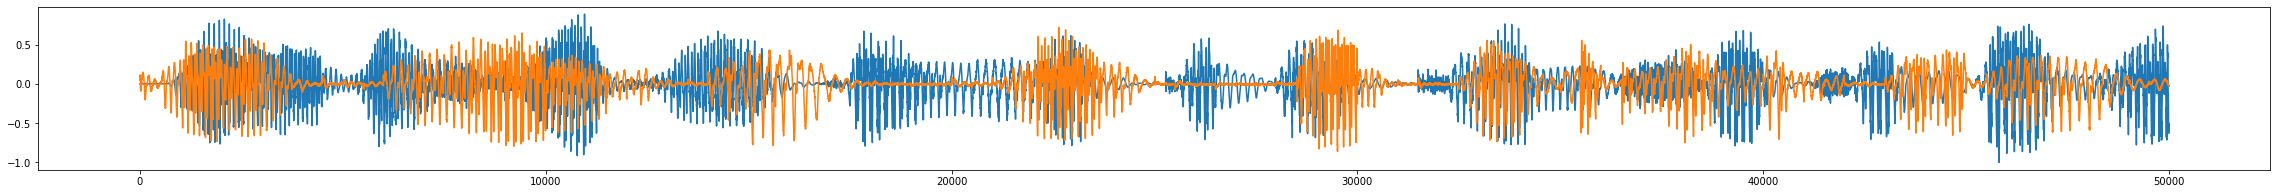

In [55]:
idx = 12
data_in = data_list[2]
data_out = apply(data_in)
plt.rcParams["figure.figsize"] = (40,3)
plt.plot(data_in[:,idx,:].reshape((-1,)))
plt.plot(data_out[:,idx,:].cpu().detach().numpy().reshape((-1,)))

In [27]:
b.shape

(10, 16, 250)

In [38]:
loss_f(torch.from_numpy(data_in).float().cuda(), data_out)

tensor(0.0759, device='cuda:0', grad_fn=<MeanBackward0>)

In [40]:
data_out.max()

tensor(0.7512, device='cuda:0', grad_fn=<MaxBackward1>)

In [41]:
import numpy as np
from scipy.io.wavfile import write

In [50]:
idx = 3
np_data_out = data_out[:,idx,:].cpu().detach().numpy().reshape((-1,))
np_data_in = data_in[:,idx,:].reshape((-1,))
scaled_out = np.int16(np_data_out/np.max(np.abs(np_data_out)) * 32767)
scaled_in = np.int16(np_data_in/np.max(np.abs(np_data_in)) * 32767)

write('test_in.wav', 24000, scaled_in)
write('test_out.wav', 24000, scaled_out)